# Prepare

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from datetime import datetime
from scipy.stats import entropy
from scipy import signal
import scipy as sp

# Two Step Task
from two_step_task import *
env = two_step_task()

/Users/Marvin/opt/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Hyperparameters
gamma = 0.9  # Discount factor for past rewards
nb_steps = 100
nb_episodes = 20000
learning_rate = 7e-4
bootstrap_n = 10

beta_v = 0.05
beta_e = 0.05

In [3]:
# Save Paths
path = "train/" + datetime.now().strftime("%m%d-%H:%M:%S")
log_dir = path+'/logs/'
ckpt_dir = path+'/ckpt/'
train_summary_writer = tf.summary.create_file_writer(log_dir)

2023-01-07 10:32:15.901151: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Training

## LOSS

In [4]:
def discount(x, gamma):
    return sp.signal.lfilter([1], [1, -gamma], x[::-1], axis=0)[::-1]

In [5]:
def compute_loss(action_probs, values, rewards, entropy):
    """Computes the combined actor-critic loss."""
    
    bootstrap_n = tf.shape(rewards)[0]
    
    value_plus = np.append(values, bootstrap_n)
    rewards_plus = np.append(rewards, bootstrap_n)
    discounted_rewards = discount(rewards_plus,gamma)[:-1]
    advantages = rewards + gamma * value_plus[1:] - value_plus[:-1]
    advantages = discount(advantages,gamma)

    critic_loss = beta_v * 0.5 * tf.reduce_sum(input_tensor=tf.square(discounted_rewards - tf.reshape(values,[-1])))
    actor_loss = -tf.reduce_sum(tf.math.log(action_probs + 1e-7) * advantages)
    entropy_loss = beta_e * entropy

    total_loss = actor_loss + critic_loss + entropy

    return total_loss, actor_loss, critic_loss, entropy_loss

## LSTM

In [6]:
num_inputs = 7 #states + reward + action + timestep= 3 + 1 + 2 + 1
num_actions = 2
num_hidden = 48

In [7]:
inputs = layers.Input(shape=(num_inputs))
state_h = layers.Input(shape=(num_hidden))
state_c = layers.Input(shape=(num_hidden))

common, states = layers.LSTMCell(num_hidden)(inputs, states=[state_h, state_c], training=True)
action = layers.Dense(num_actions, activation="softmax")(common)
critic = layers.Dense(1)(common)

model = keras.Model(inputs=[inputs,state_h,state_c], outputs=[action, critic, states], )
optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)

#model.save('init.h5')
#model = keras.models.load_model('init.h5')

## Run

In [8]:
#start = datetime.now()
for episode in range(nb_episodes):
    with tf.GradientTape() as tape:
        state = env.reset()
        action_probs_history = []
        critic_value_history = []
        rewards_history = []
        reward = 0.0
        action_onehot = np.zeros((2))
        cell_state = [tf.zeros((1,num_hidden)),tf.zeros((1,num_hidden))]
        entropy = 0.0
    
        for timestep in range(nb_steps):
            input = np.concatenate((state, action_onehot, [reward], [timestep]),dtype = np.float32)
            input = tf.expand_dims(input,0)
            
            # Predict action probabilities and estimated future rewards from environment state
            action_probs, critic_value, cell_state = model([input,cell_state[0],cell_state[1]])
            
            critic_value_history.append(tf.squeeze(critic_value))

            # Sample action from action probability distribution
            action_probs = tf.squeeze(action_probs)
            action = np.random.choice(num_actions, p=action_probs.numpy())
            action_probs_history.append(action_probs[action])
            action_onehot = np.zeros((2))
            action_onehot[action] = 1.0

            # Apply the sampled action in our environment
            state, reward, done, _ = env.trial(action)
            #state, reward, done, _ = env.step(np.random.randint(0,2))
            rewards_history.append(reward)
            
            # entropy
            entropy += sp.stats.entropy(action_probs)
        
        # Calculating loss values to update our network
        # total_loss, actor_loss, critic_loss, entropy_loss = compute_loss(
        #     action_probs_history, critic_value_history, rewards_history, entropy)
        
        total_loss, actor_loss, critic_loss, entropy_loss = compute_loss(
            tf.convert_to_tensor(action_probs_history,dtype=tf.float32), 
            tf.convert_to_tensor(critic_value_history, dtype=tf.float32), 
            tf.convert_to_tensor(rewards_history, dtype=tf.float32), 
            entropy)
                
        # Backpropagation
        grads = tape.gradient(total_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        # Log
        with train_summary_writer.as_default():
            tf.summary.scalar('loss/total_loss', total_loss, step=episode)
            tf.summary.scalar('loss/actor_loss', actor_loss, step=episode)
            tf.summary.scalar('loss/critic_loss', critic_loss, step=episode)
            tf.summary.scalar('loss/entropy', entropy_loss, step=episode)
            tf.summary.scalar('game/reward', np.sum(rewards_history), step=episode)
            tf.summary.histogram('game/action_probs', action_probs_history, step=episode)

    # if episode % 10 == 0:
    #     print(datetime.now() - start)
        
    # Checkpoint
    if episode % 2000 == 0:
        checkpoint = tf.train.Checkpoint(model)
        save_path = checkpoint.save(ckpt_dir+'checkpoints_'+str(episode)+'/two_steps.ckpt')

In [9]:
model.save(path+'/model.h5')

In [10]:
%load_ext tensorboard

# Testing

In [10]:
model_path = "train/0104-16:37:22/model.h5"
test_dir = "test/" + datetime.now().strftime("%m%d-%H:%M:%S") +'/logs/'
test_summary_writer = tf.summary.create_file_writer(test_dir)

#test_model = keras.models.load_model('train/0105-21:10:53/model.h5')
test_model = model
test_episode = 300

In [11]:
for episode in range(test_episode):
    state = env.reset()
    action_probs_history = []
    critic_value_history = []
    rewards_history = []
    episode_reward = 0
    reward = 0.0
    action_onehot = np.zeros((2))
    cell_state = [tf.zeros((1,num_hidden)),tf.zeros((1,num_hidden))]
    
    episode_entropy = tf.zeros(())
    
    with tf.GradientTape() as tape:
        for timestep in range(nb_steps):
            
            input = np.append(state,action_onehot)
            input = np.append(input,reward)
            input = np.append(input,timestep)
            input = tf.reshape(input, (1, num_inputs))

            # Predict action probabilities and estimated future rewards from environment state
            action_probs, critic_value, cell_state = test_model([input,cell_state[0],cell_state[1]])
            
            critic_value_history.append(tf.squeeze(critic_value))

            # Sample action from action probability distribution
            action_probs = tf.squeeze(action_probs)
            action = np.random.choice(num_actions, p=action_probs.numpy())
            action_probs_history.append(action_probs[action])
            action_onehot[action] = 1

            # Apply the sampled action in our environment
            state, reward, done, _ = env.trial(action)
            
            #state, reward, done, _ = env.step(np.random.randint(0,2))
            rewards_history.append(reward)
            episode_reward += reward
            
            #entropy
            #entropy = -tf.math.reduce_sum(tf.math.multiply(tmp,tf.math.log(tmp + 1e-7)))
            entropy = sp.stats.entropy(action_probs)
            episode_entropy += entropy
            
            if done: break


        # # Calculating loss values to update our network
        # total_loss, actor_loss, critic_loss, entropy = compute_loss(
        #     tf.convert_to_tensor(action_probs_history,dtype=tf.float32), 
        #     tf.convert_to_tensor(critic_value_history, dtype=tf.float32), 
        #     tf.convert_to_tensor(rewards_history, dtype=tf.float32), 
        #     episode_entropy)
        
        # with test_summary_writer.as_default():
        #     tf.summary.scalar('loss/total_loss', total_loss, step=episode)
        #     tf.summary.scalar('loss/actor_loss', actor_loss, step=episode)
        #     tf.summary.scalar('loss/critic_loss', critic_loss, step=episode)
        #     tf.summary.scalar('loss/entropy', episode_entropy, step=episode)
        #     tf.summary.scalar('game/reward', episode_reward, step=episode)
        #     tf.summary.histogram('game/action_probs', action_probs_history, step=episode)


In [12]:
print(env.stayProb())

[[[902362. 102153.]
  [120747.  29417.]]

 [[472897. 131224.]
  [223822.  27078.]]]
[[[0.89830615 0.10169385]
  [0.80410085 0.19589915]]

 [[0.78278524 0.21721476]
  [0.89207652 0.10792348]]]


[[[902362. 102153.]
  [120747.  29417.]]

 [[472897. 131224.]
  [223822.  27078.]]]


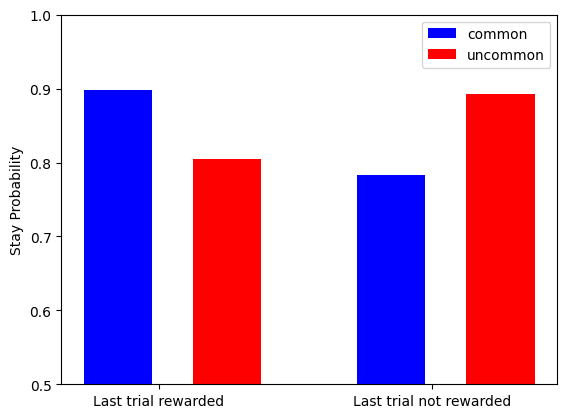

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
x = np.arange(2)
ax.set_ylim([0.0, 1.0])
ax.set_ylabel('Stay Probability')

stay_probs = env.stayProb()

common = [stay_probs[0,0,0],stay_probs[1,0,0]]
uncommon = [stay_probs[0,1,0],stay_probs[1,1,0]]

ax.set_xticks([1.3,3.3])
ax.set_xticklabels(['Last trial rewarded', 'Last trial not rewarded'])

c = plt.bar([1,3],  common, color='b', width=0.5)
uc = plt.bar([1.8,3.8], uncommon, color='r', width=0.5)
plt.ylim(0.5,1)
ax.legend( (c[0], uc[0]), ('common', 'uncommon') )
